In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist
import pickle

from plotter import *

In [2]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.9

with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap.json') as f:
  pmap = json.load(f)

In [3]:
year = '2017'
nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
outsum = processor.dict_accumulator()

In [4]:
# Higgs mass window
mbb_min = 110
mbb_max = 138

In [5]:
def significance(s,b):
    if b==0:
        return 0
    z_squared = 2.0*(s+b)*np.log(1.0+1.0*s/b) - 2.0*s
    return np.sqrt(z_squared)

In [6]:
repickle=True

# Check if pickle exists, and don't re-create it if it does
picklename = 'pickles/'+str(year)+'_templates1.pkl'
if os.path.isfile(picklename):
    repickle=False

In [7]:
# Load all files - this takes a while
if repickle:
    nfiles = len(subprocess.getoutput("ls infiles-split/"+year+"*.json").split())
    for n in range(1,nfiles+1):

        with open('infiles-split/'+year+'_'+str(n)+'.json') as f:
            infiles = json.load(f)
    
        filename = '/myeosdir/vh-charm-category/outfiles/'+year+'_'+str(n)+'.coffea'
        #filename = 'outfiles/'+year+'_'+str(n)+'.coffea'
        if os.path.isfile(filename):
            out = util.load(filename)
            outsum.add(out)
        else:
            print('Missing file '+str(n),infiles.keys())
            #print("File " + filename + " is missing")
        
    scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
    outsum['templates-vh-1'].scale(scale_lumi, 'dataset')
    
    # Use pmap to group the datasets together
    templates = outsum['templates-vh-1'].group('dataset', hist.Cat('process', 'Process'), pmap)

    outfile = open(picklename, 'wb')
    pickle.dump(templates, outfile, protocol=-1)
    outfile.close()

In [8]:
# Read the histogram from the pickle file
templates1 = pickle.load(open(picklename,'rb')).integrate('region','signal')

In [9]:
templates1.sum('pt1','pt2','ddb2','msd1','msd2').values()

{('ZH',): array([2.10755762, 4.77129177]),
 ('WH',): array([2.47610322, 5.43290897]),
 ('ttH',): array([1.80866315, 1.25148068]),
 ('VBF',): array([1.06182479, 1.89042155]),
 ('ggF',): array([2.85214218, 4.87955622]),
 ('ggF-powheg',): array([ 4.98075179, 10.21901184]),
 ('QCD',): array([223628.3453825 ,   6885.72813378]),
 ('VV',): array([251.42102886,  32.12491312]),
 ('Wjets',): array([7002.42029551,  240.39954188]),
 ('Zjets',): array([3238.4599998 ,  386.50007347]),
 ('ttbar',): array([2502.32019436,  536.54371104]),
 ('singlet',): array([451.18038814,  76.90403935]),
 ('data',): array([208701.,   7093.]),
 ('muondata',): array([4507.,  629.])}

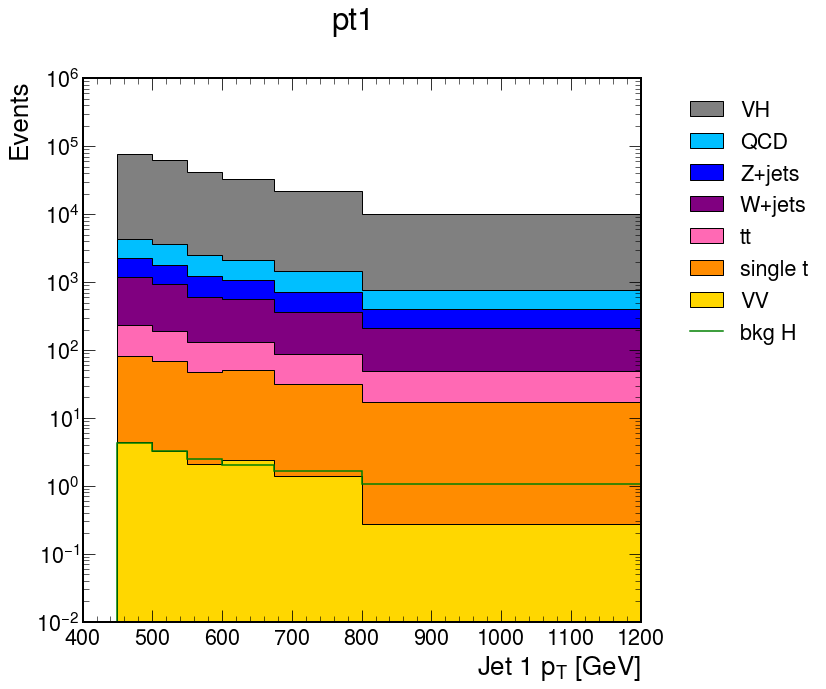

In [10]:
plot_mconly_vh(templates1.sum('ddb1','ddb2','msd1','msd2','pt2'),'pt1','pt1')

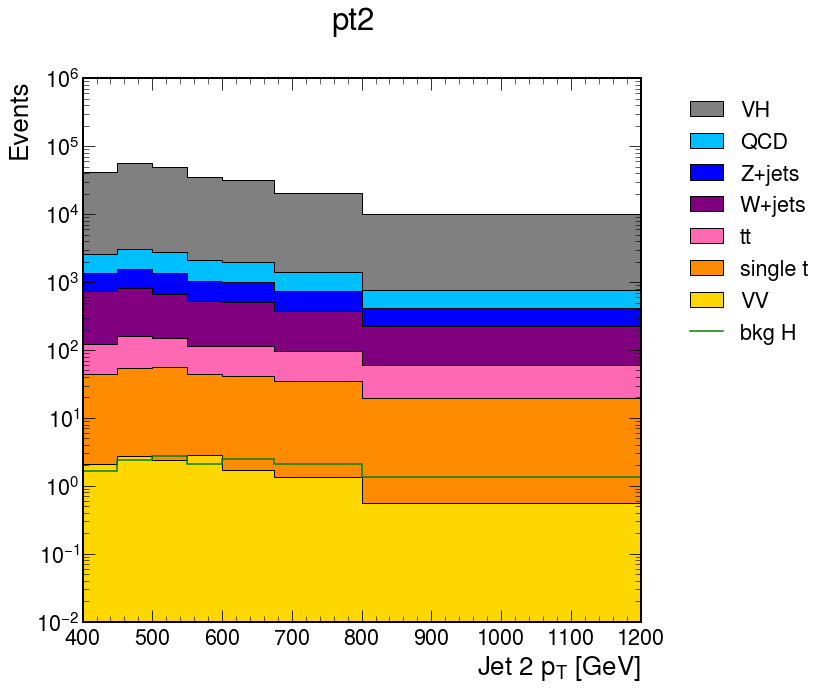

In [11]:
plot_mconly_vh(templates1.sum('ddb1','ddb2','msd1','msd2','pt1'),'pt2','pt2')

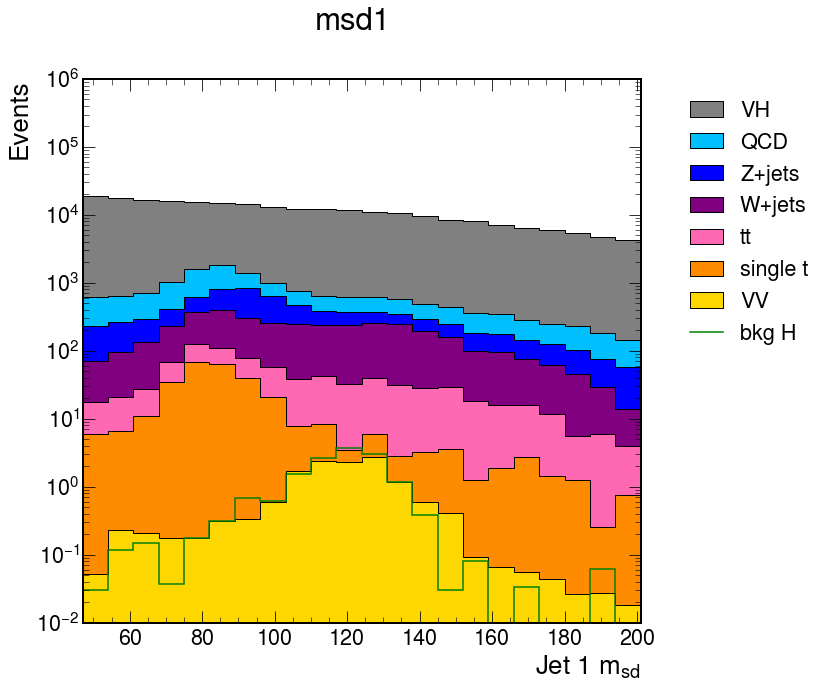

In [12]:
plot_mconly_vh(templates1.sum('ddb1','ddb2','msd2','pt1','pt2'),'msd1','msd1')

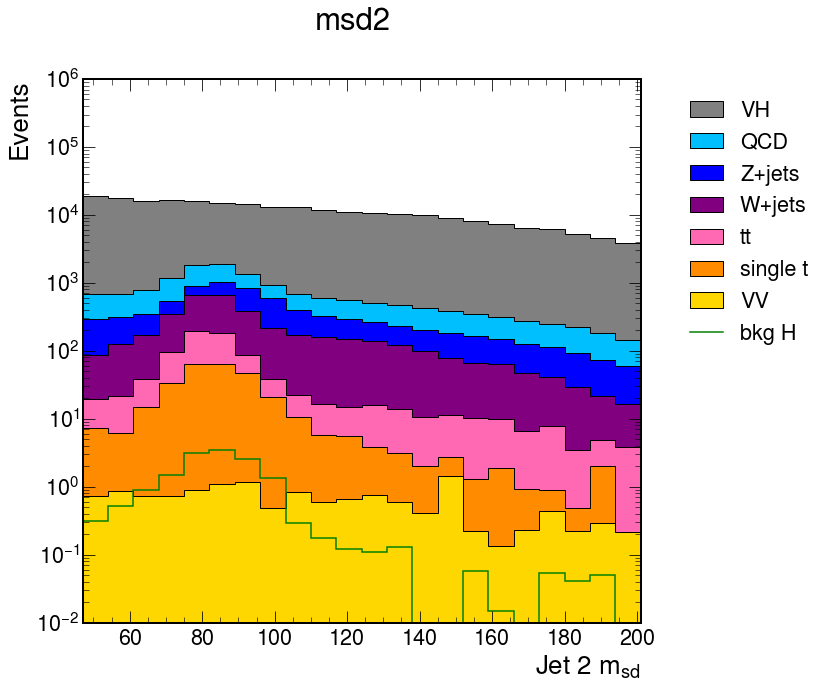

In [13]:
plot_mconly_vh(templates1.sum('ddb1','ddb2','msd1','pt1','pt2'),'msd2','msd2')

In [14]:
mc = ['QCD','Wjets','Zjets','ttbar','singlet','VV','ggF','VBF','WH','ZH','ttH']

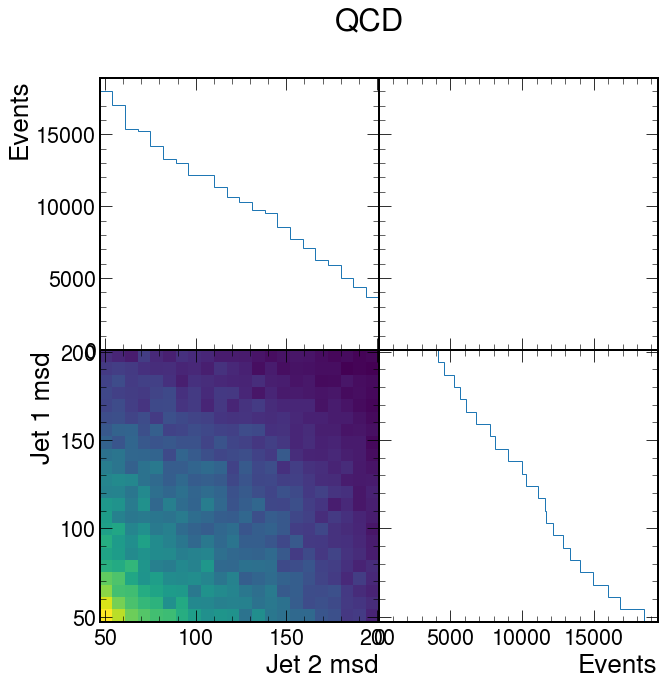

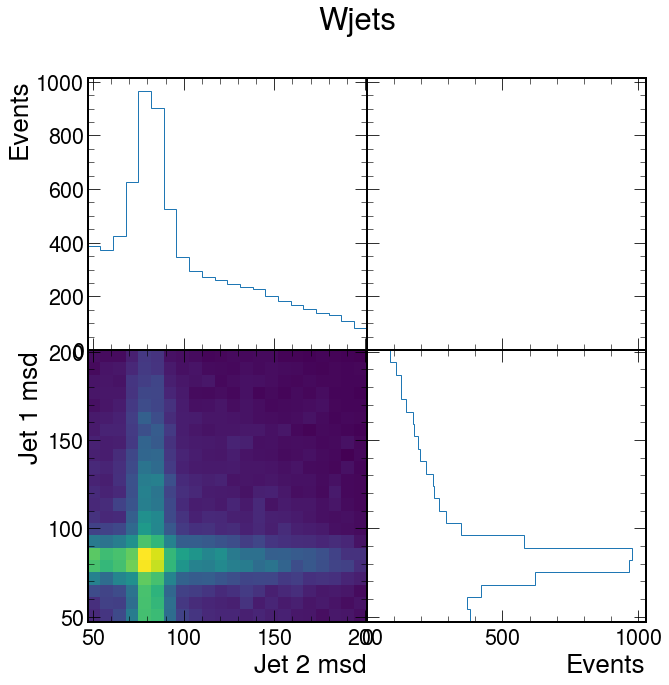

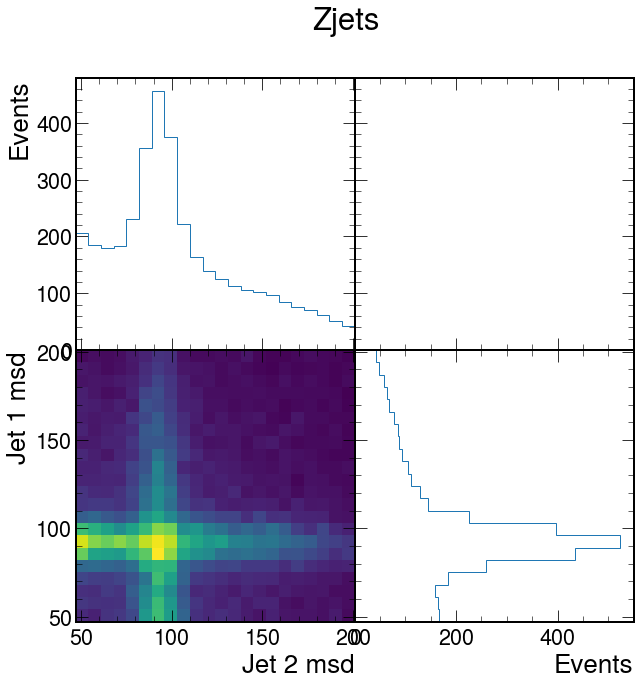

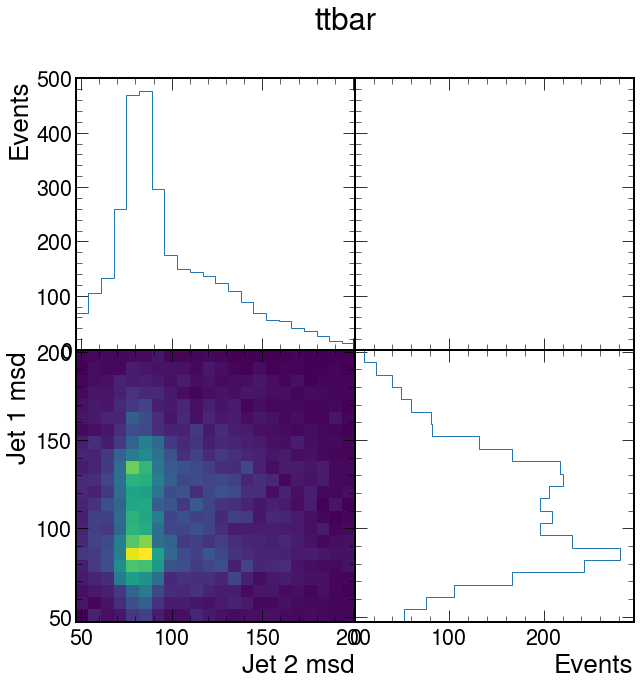

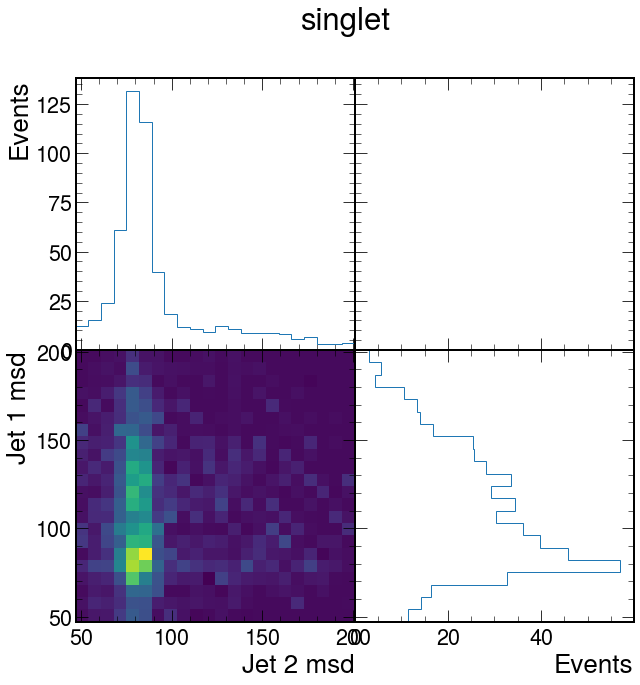

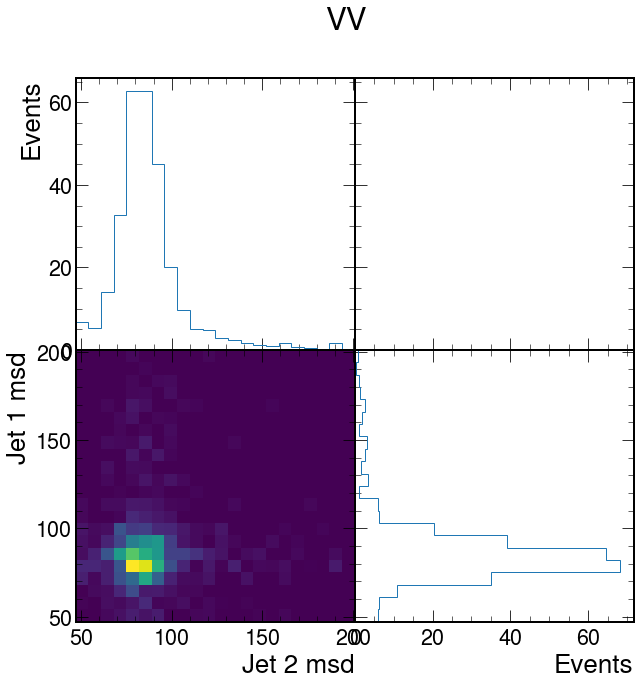

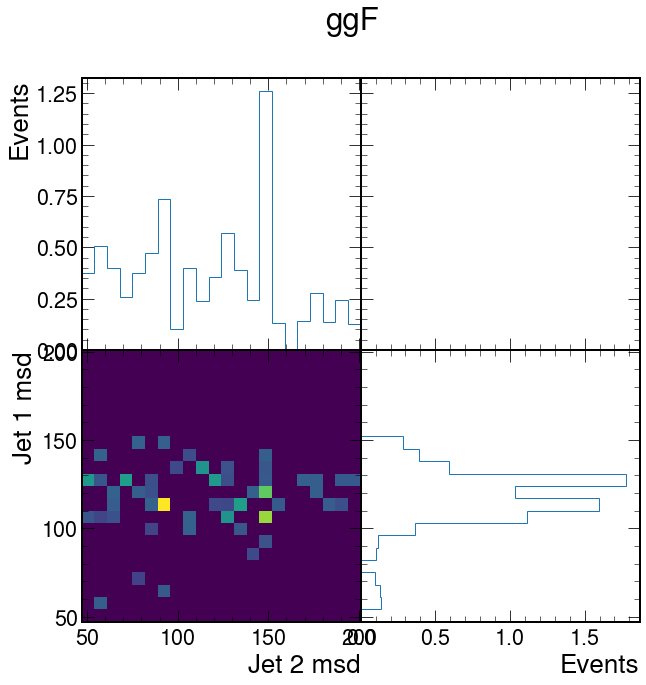

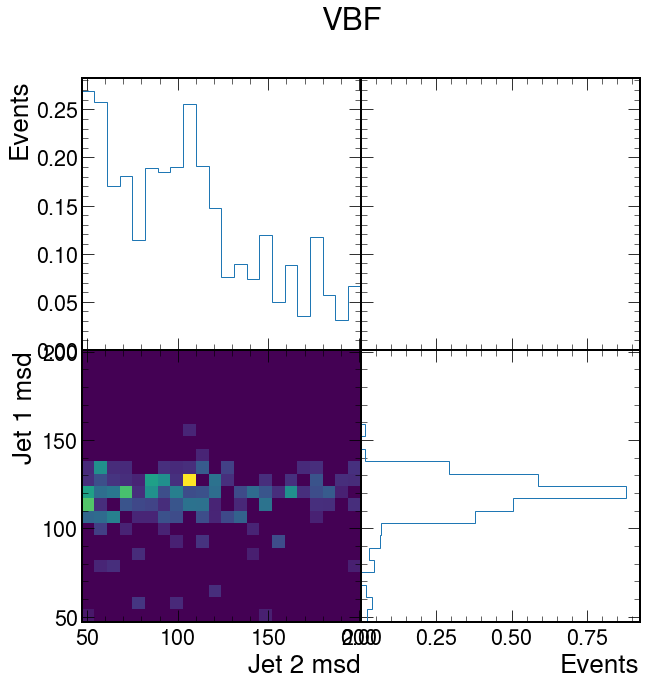

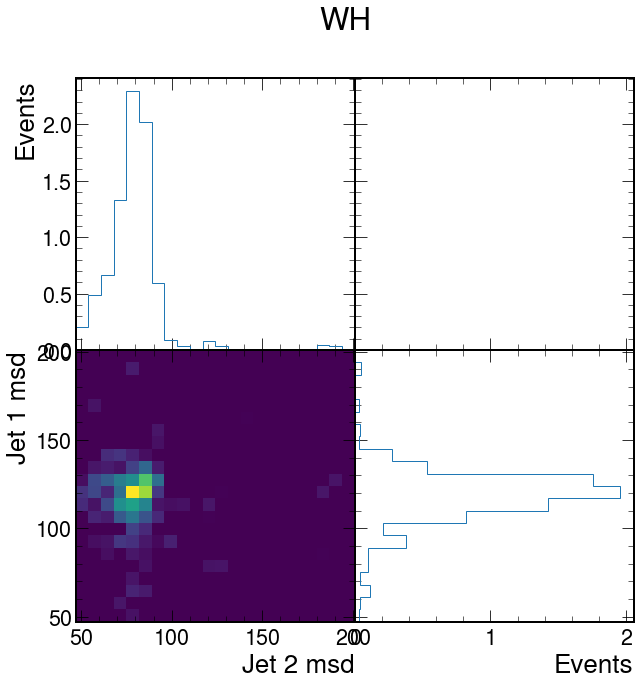

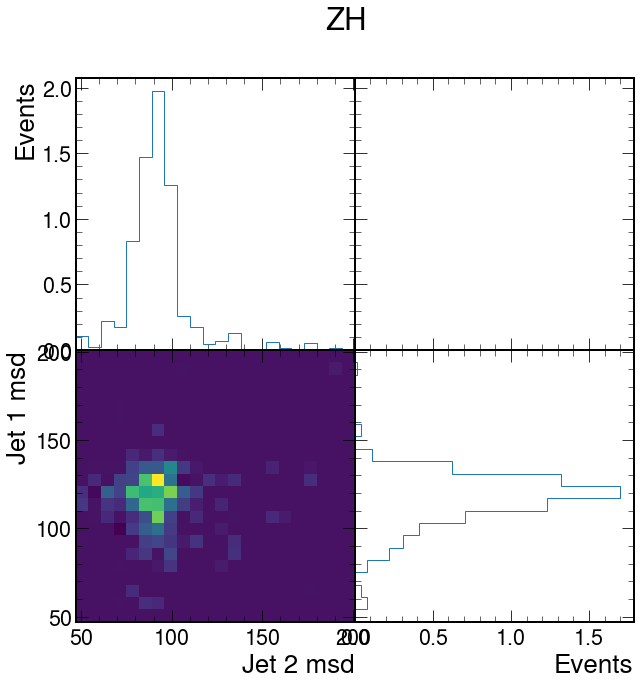

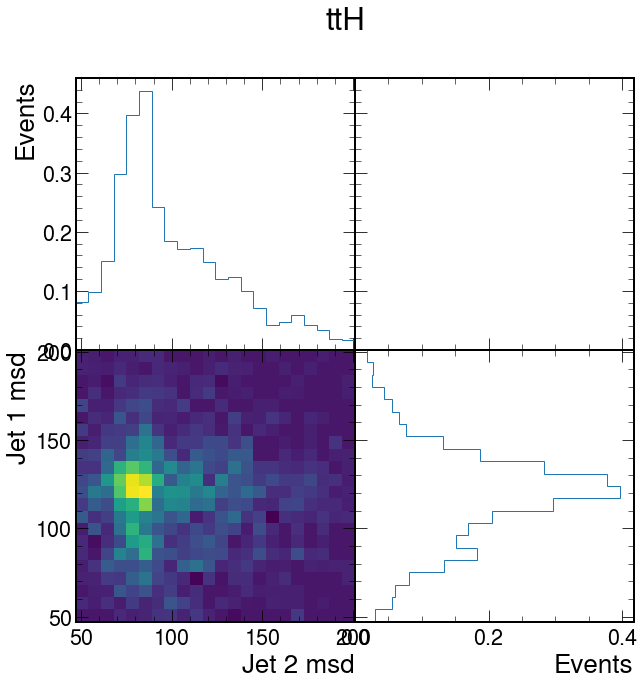

In [15]:
for p in mc:
    plot_2d(templates1.sum('pt1','pt2','ddb1','ddb2').integrate('process',p),'msd',year+'/'+p,p)

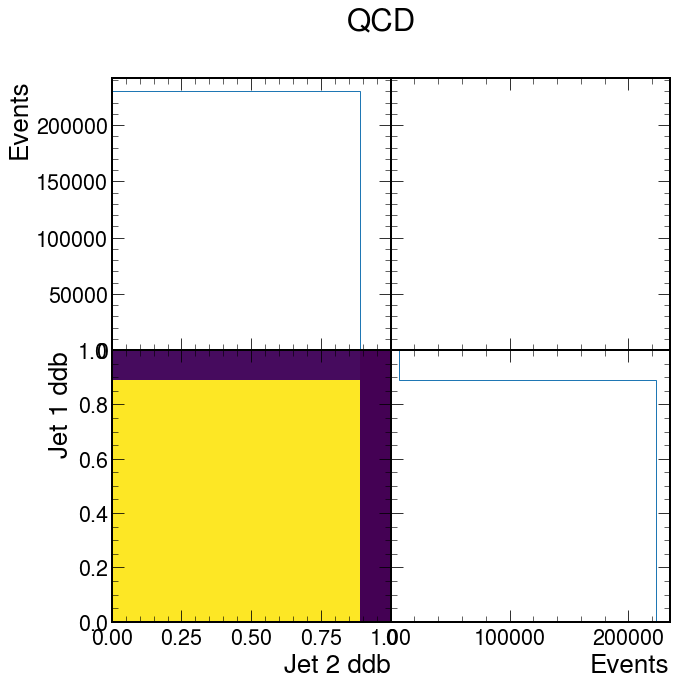

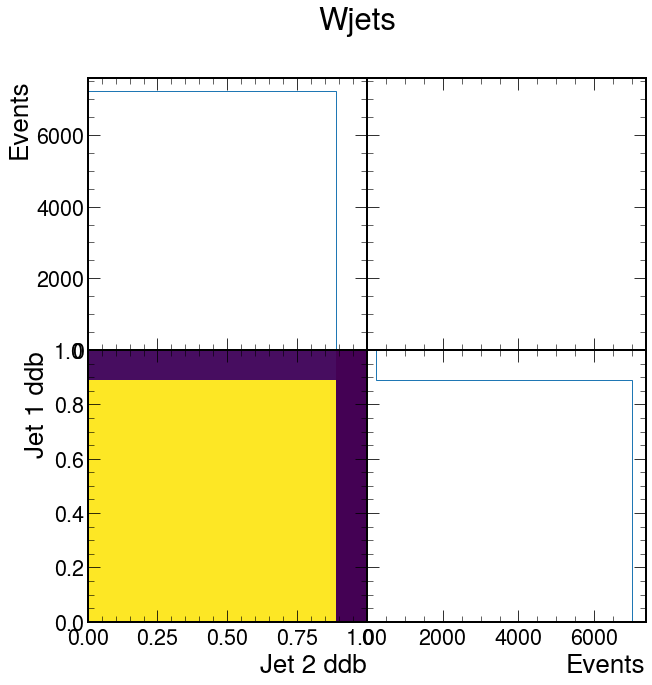

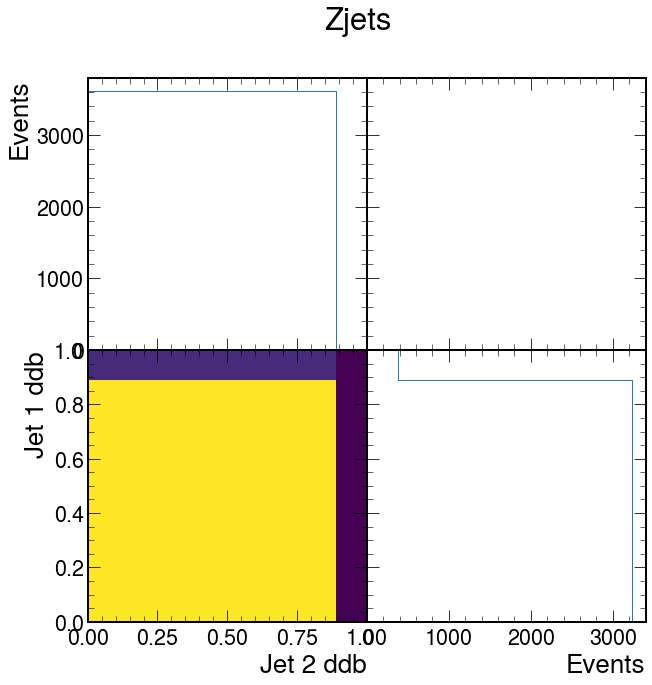

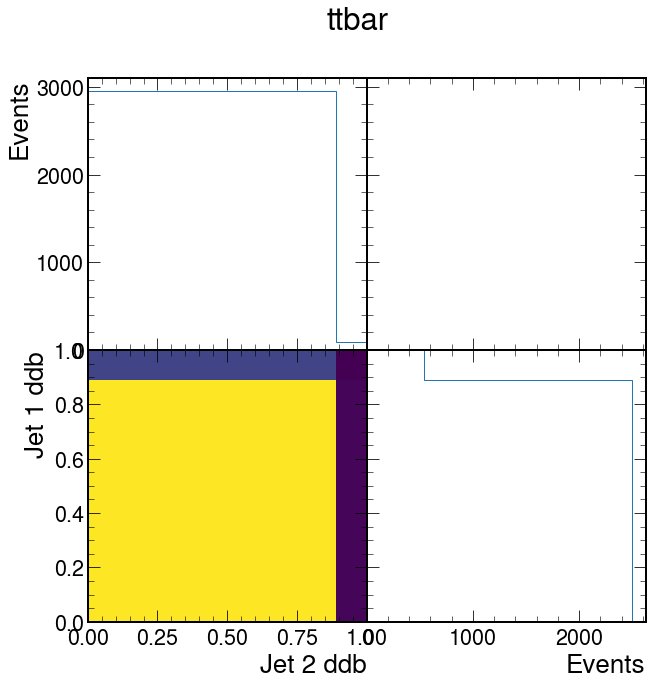

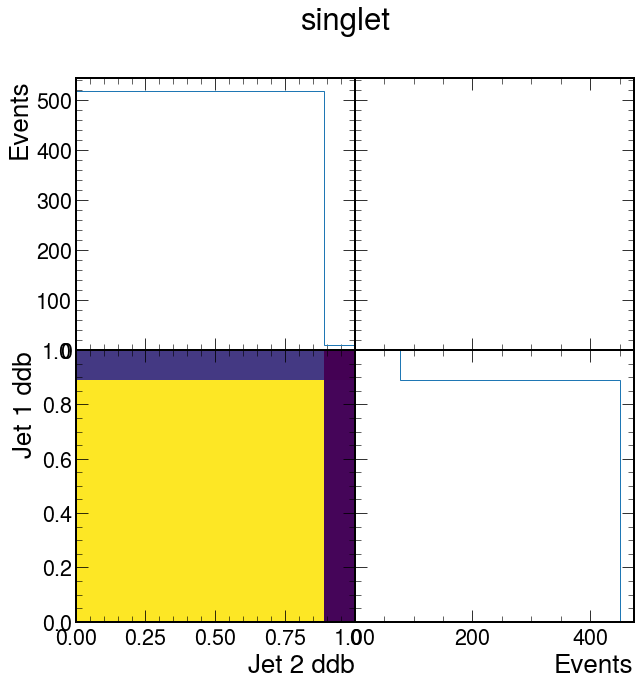

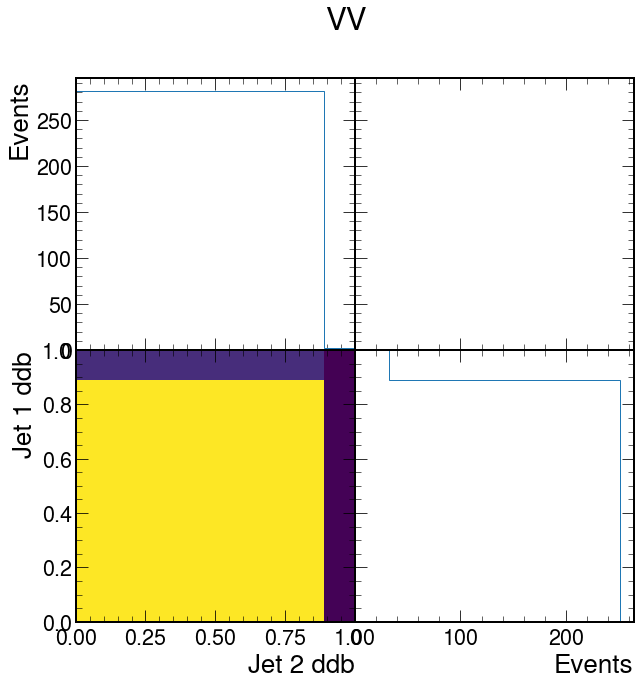

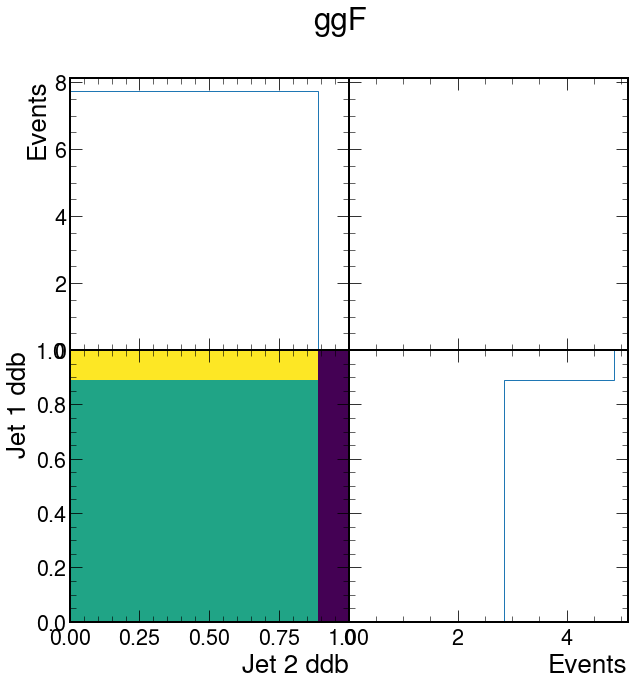

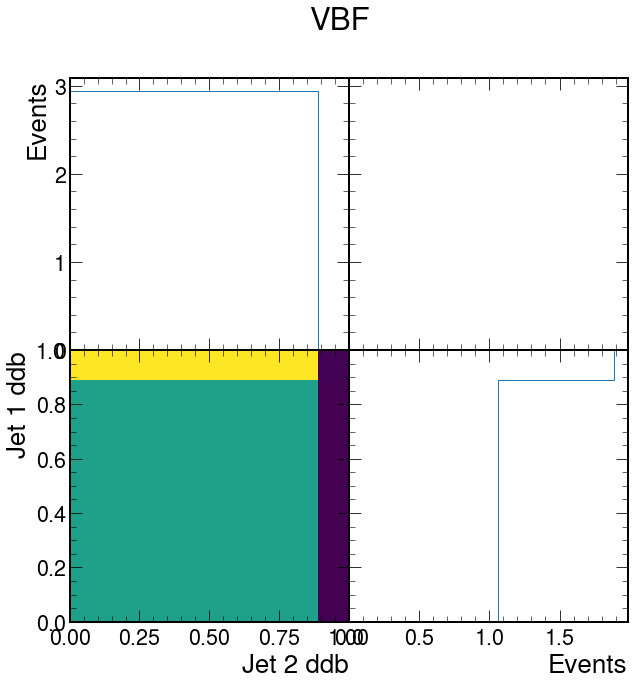

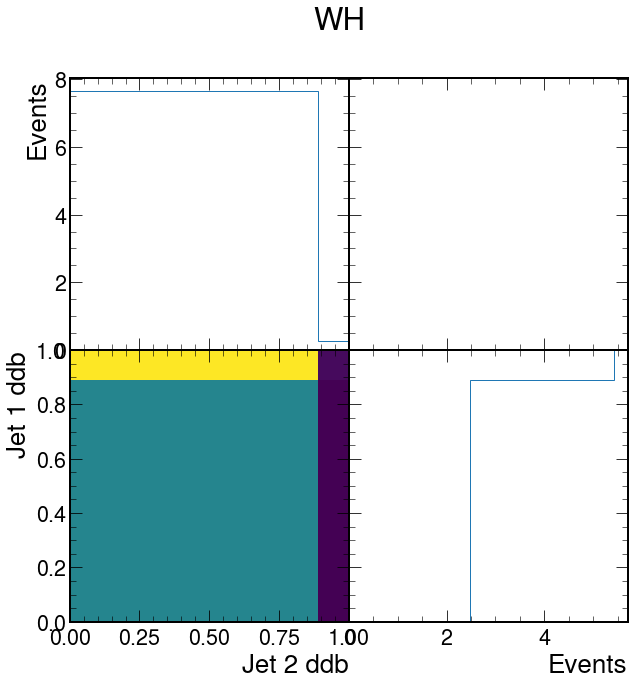

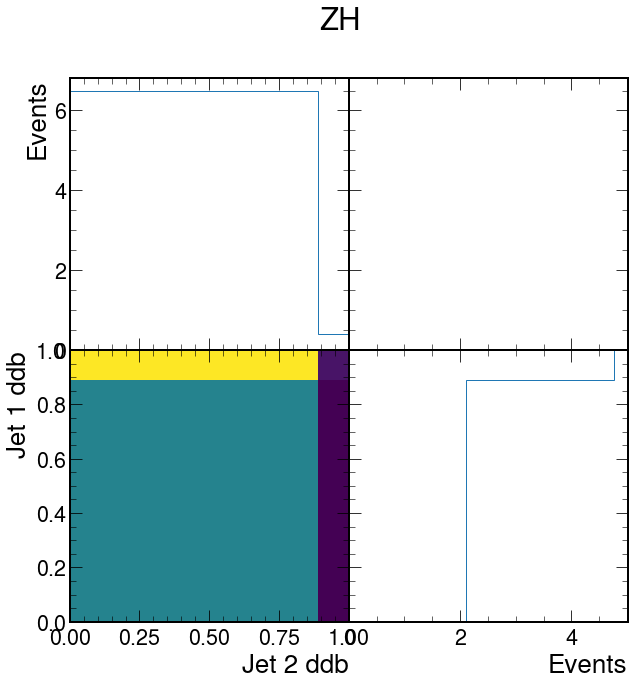

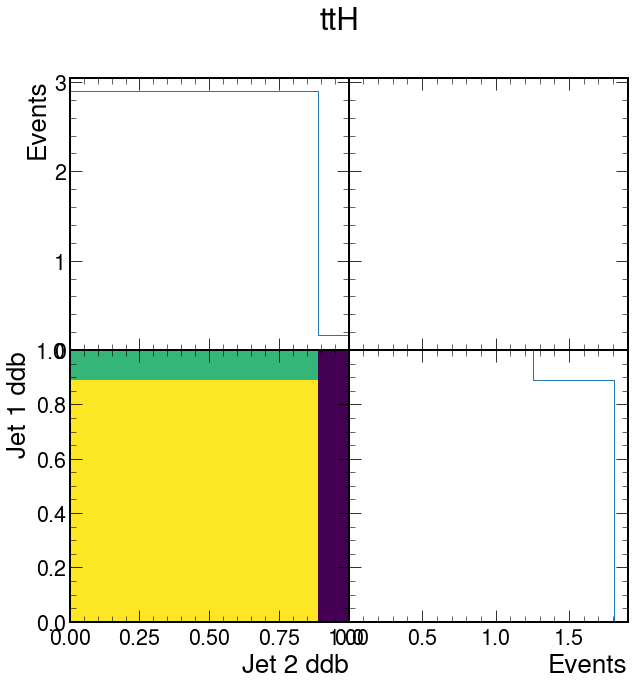

In [16]:
for p in mc:
    plot_2d(templates1.sum('pt1','pt2','msd1','msd2').integrate('process',p),'ddb',year+'/'+p,p)

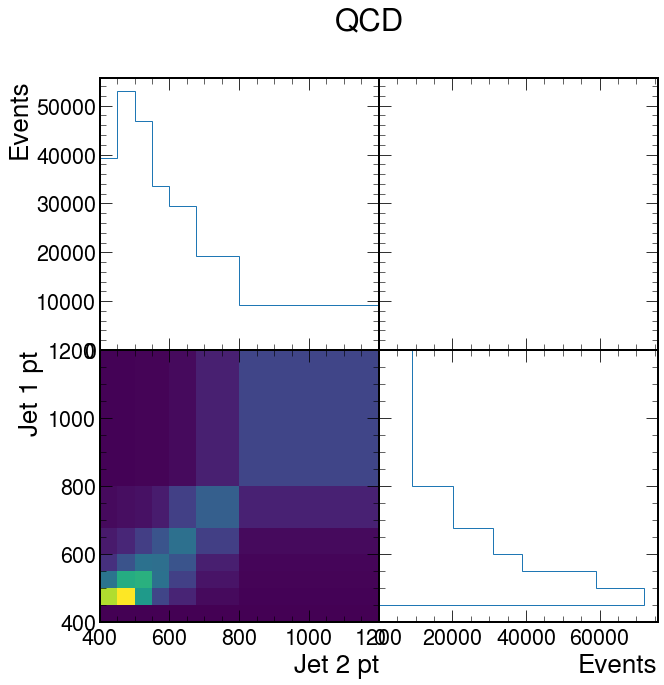

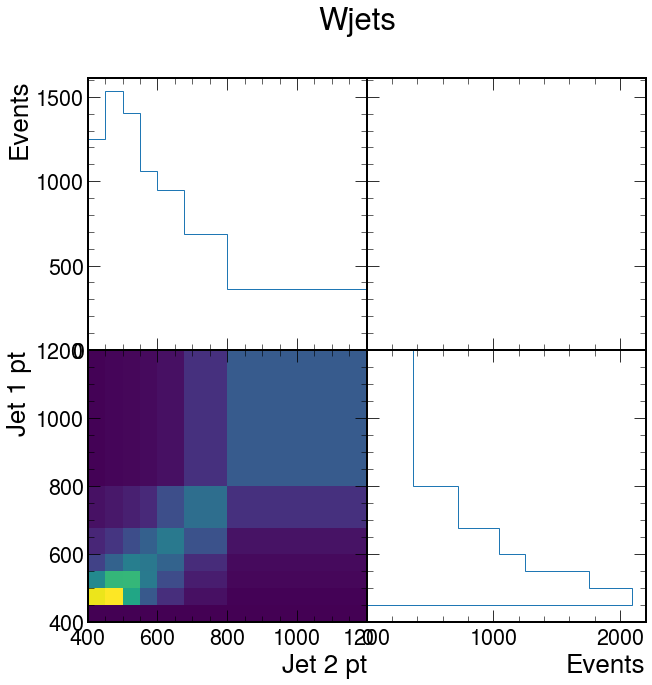

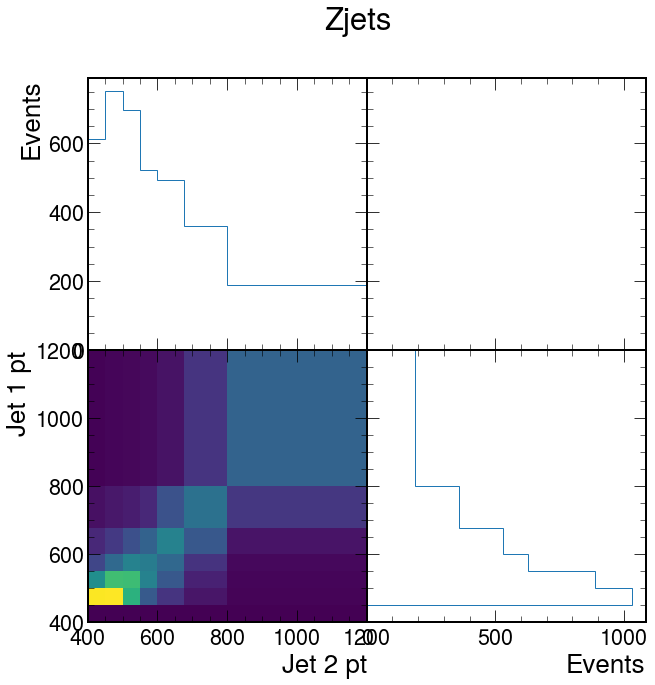

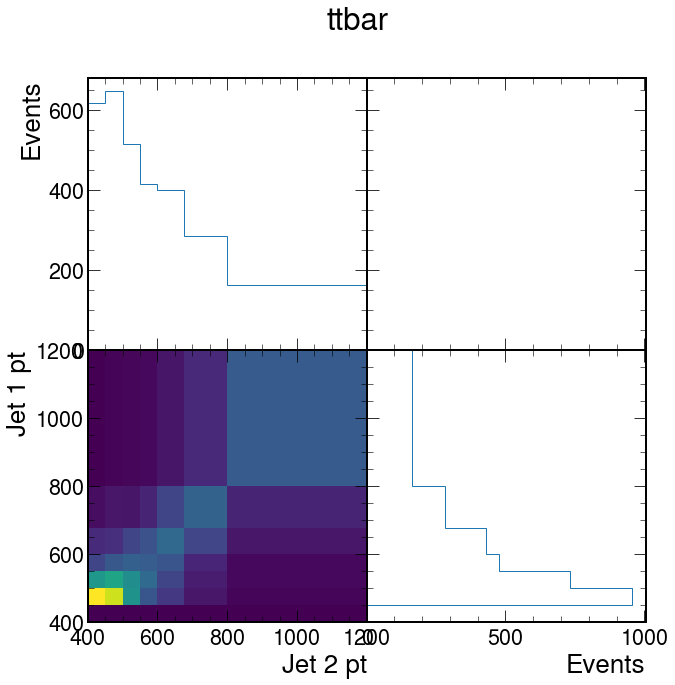

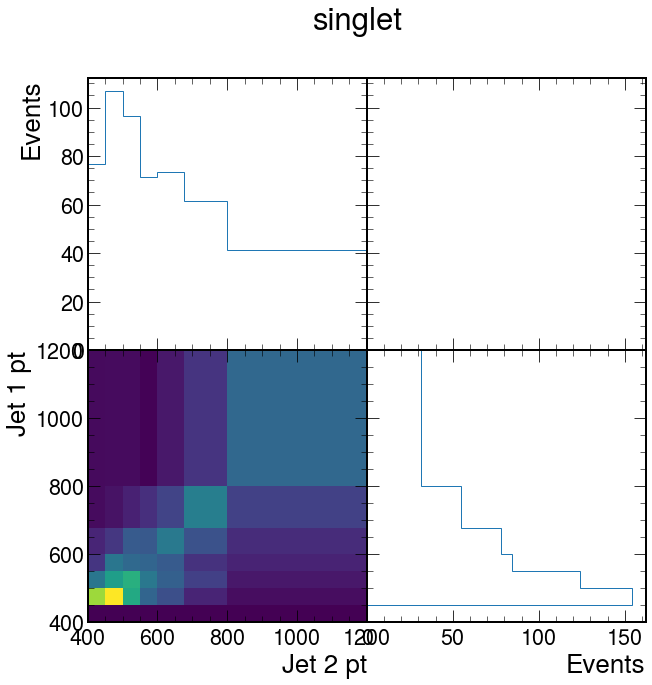

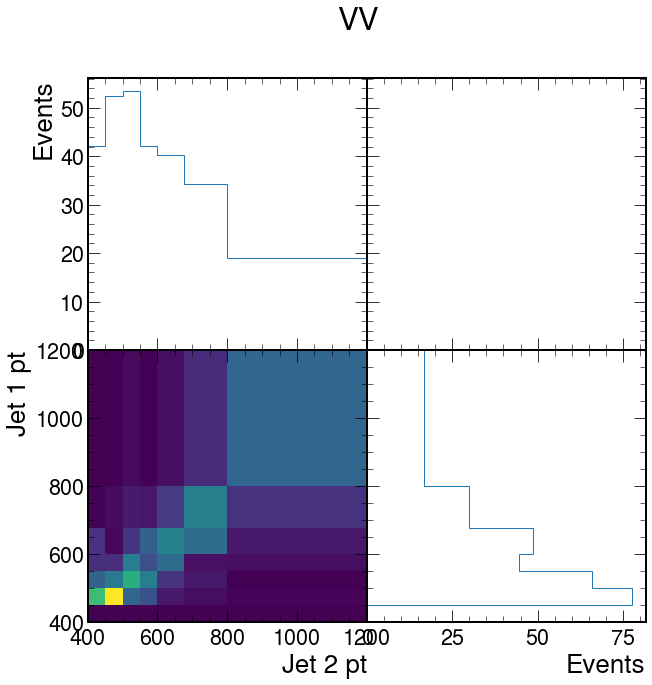

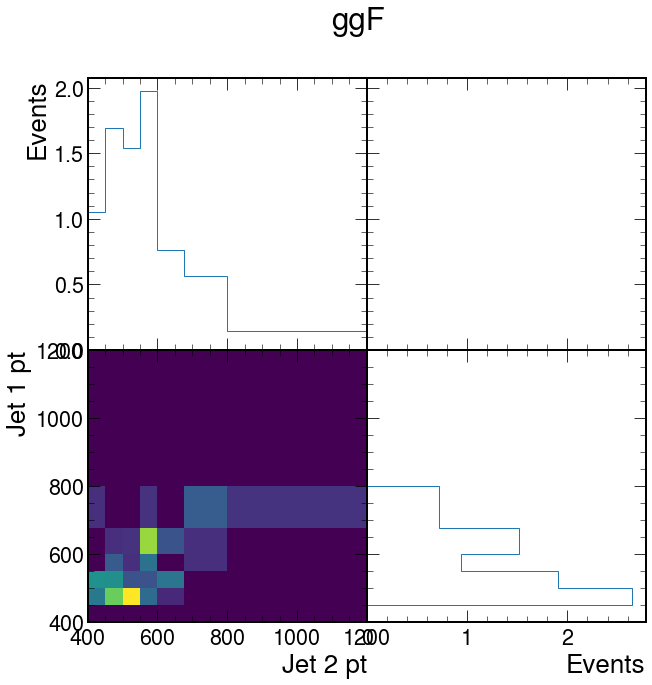

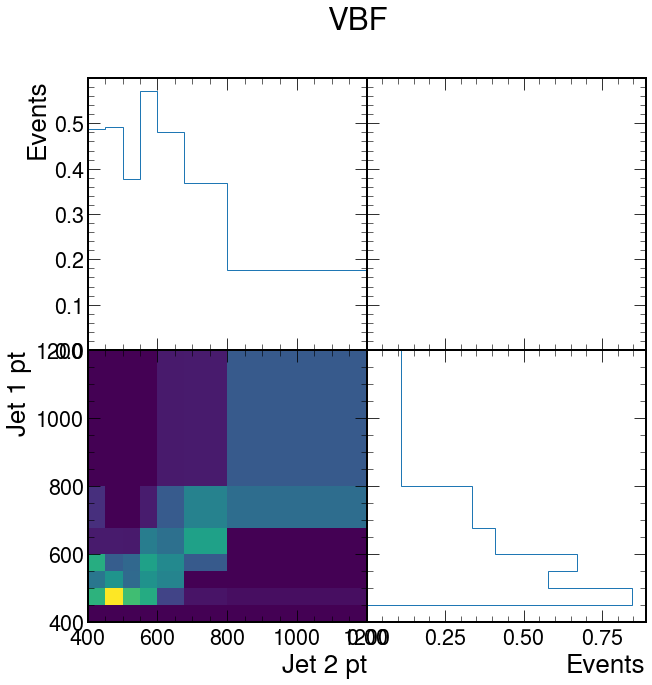

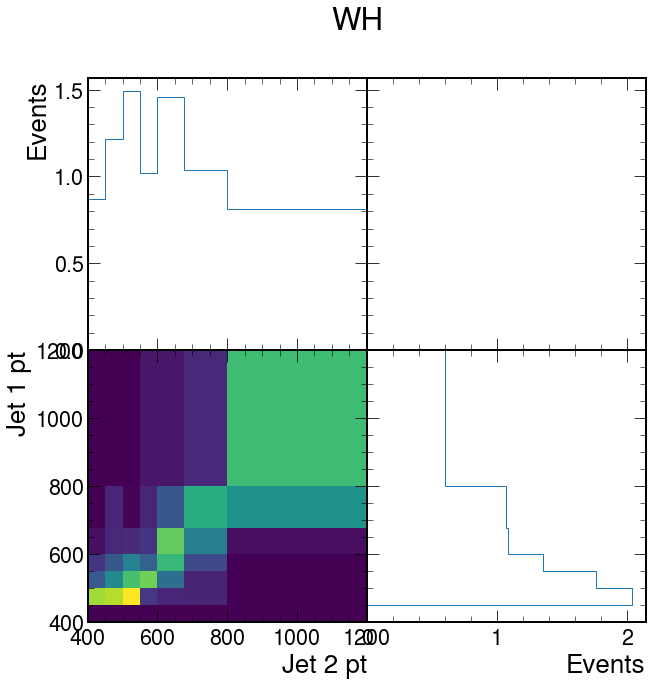

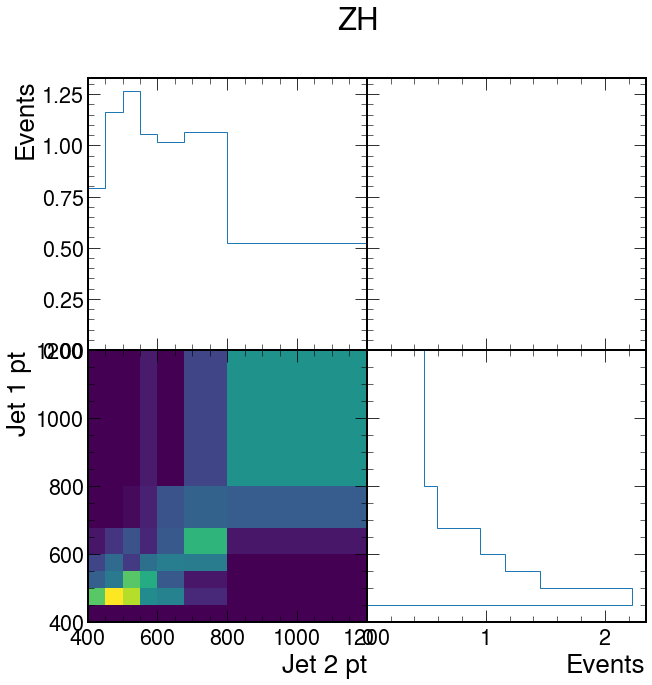

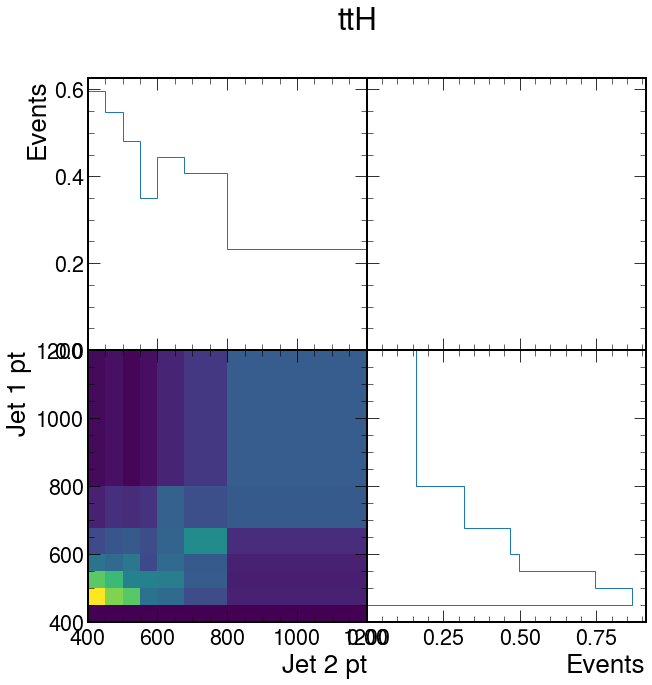

In [17]:
for p in mc:
    plot_2d(templates1.sum('msd1','msd2','ddb1','ddb2').integrate('process',p),'pt',year+'/'+p,p)

0.2811031076360643
[ 68 103]


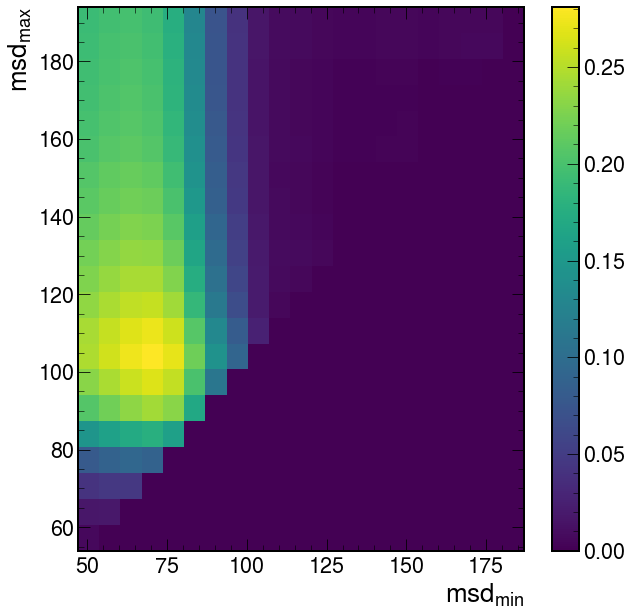

In [18]:
if year == '2017':

    # msd1 = H
    x = templates1.integrate('msd1',int_range=slice(mbb_min, mbb_max)).integrate('ddb1',int_range=slice(0.89,1))
    
    cuts3 = []
    sigs3 = []

    msd2_slices = [i*7+40 for i in range(1,23)]
    for msd2_min in msd2_slices:
        for msd2_max in msd2_slices:
            if msd2_max <= msd2_min:
                continue

            sliced = x.sum('pt1','pt2','ddb2').integrate('msd2',int_range=slice(msd2_min,msd2_max))
            s = sliced.values()[('ZH',)] + sliced.values()[('WH',)]
            b = sliced.values()[('ggF',)] + sliced.values()[('VBF',)] + sliced.values()[('ttH',)] 
            b += sliced.values()[('QCD',)] + sliced.values()[('Wjets',)] + sliced.values()[('Zjets',)] + sliced.values()[('VV',)] + sliced.values()[('ttbar',)] + sliced.values()[('singlet',)]
            
            sigs3 += [significance(s,b)]
            cuts3 += [[msd2_min,msd2_max]]
        
    cuts3 = np.array(cuts3)
    print(max(sigs3))
    print(cuts3[np.argmax(sigs3)])

    msd_min_vh = cuts3[np.argmax(sigs3)][0]
    msd_max_vh = cuts3[np.argmax(sigs3)][1]

    plt.hist2d(cuts3[:,0], cuts3[:,1], density=False, weights=sigs3, bins=[21,21]);
    plt.xlabel('$msd_{min}$');
    plt.ylabel('$msd_{max}$');
    plt.colorbar()
    plt.savefig(year+'/vh_2d_msdminmax.png')

In [19]:
sr = templates1.sum('pt1','pt2','ddb2').integrate('msd1',int_range=slice(mbb_min, mbb_max)).integrate('msd2',int_range=slice(msd_min_vh,msd_max_vh)).integrate('ddb1',int_range=slice(0.89,1)).values()
sr

{('ZH',): 3.0497450818749847,
 ('WH',): 3.4631678047149275,
 ('ttH',): 0.37160432270397614,
 ('VBF',): 0.5037814491501225,
 ('ggF',): 0.853104300214208,
 ('ggF-powheg',): 2.2260074880301683,
 ('QCD',): 398.5248213449404,
 ('VV',): 0.45817540877827956,
 ('Wjets',): 12.731609941850985,
 ('Zjets',): 9.080690177428302,
 ('ttbar',): 96.7141506588709,
 ('singlet',): 15.40380247848389,
 ('data',): 450.0,
 ('muondata',): 45.0}

In [20]:
# significance
s = sr[('WH',)] + sr[('ZH',)]
b = sr[('QCD',)] + sr[('Zjets',)] + sr[('Wjets',)]  + sr[('VV',)] + sr[('ttbar',)] +sr[('singlet',)] + sr[('ggF',)] + sr[('VBF',)] + sr[('ttH',)]

print(s,b)
print(significance(s,b))

sigma_2016 = 0.22765828968582566
sigma_2017 = 0.3187168794005945
sigma_2018 = 0.3295974584216346

# this only makes sense in the mass window of Higgs

6.512912886589913 534.641740082421
0.28110310763605795


In [21]:
np.sqrt(sigma_2016**2 + sigma_2017**2 + sigma_2018**2)

0.511901582997679